In [1]:
import sys
import os

# 添加 factor_evaluation.pyd 所在的目录到系统路径
pyd_path = r"D:\MG\！internship\！4L CAPITAL\因子评估器"
sys.path.append(pyd_path)

# 导入模块
from factor_evaluation import FactorEvaluation
from factor_evaluation import DataService
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

In [4]:
def rsrs_beta_r2_factor(df, window_N=16):
    """
    高效计算RSRS_beta和R-squared
    """
    low = df['low']
    high = df['high']
    n = len(df)
    
    # 预分配数组
    beta = np.full(n, np.nan)
    r_squared = np.full(n, np.nan)
    
    # 预计算滚动统计量
    low_mean = low.rolling(window_N).mean()
    high_mean = high.rolling(window_N).mean()
    low_var = low.rolling(window_N).var(ddof=1)
    cov = low.rolling(window_N).cov(high)
    
    # 使用向量化计算
    for i in range(window_N-1, n):
        if low_var[i] < 1e-5:  # 避免除以零
            beta[i] = 0
            r_squared[i] = 0
            continue
            
        beta[i] = cov[i] / low_var[i]
        
        # 计算R-squared
        y = high.iloc[i-window_N+1:i+1].values
        y_pred = low.iloc[i-window_N+1:i+1].values * beta[i] + (high_mean[i] - beta[i]*low_mean[i])
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - high_mean[i])**2)
        r_squared[i] = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    beta_series = pd.Series(beta, index=df.index).ffill().fillna(0)
    r2_series = pd.Series(r_squared, index=df.index).ffill().fillna(0)
    return beta_series, r2_series

def rsrs_zscore_r2_factor(df, window_N=16, window_M=300):
    """高效计算修正标准分RSRS指标"""
    beta, r_squared = rsrs_beta_r2_factor(df, window_N)
    rolling_mean = beta.rolling(window_M, min_periods=1).mean()
    rolling_std = beta.rolling(window_M, min_periods=1).std().replace(0, 1e-5)
    return (beta - rolling_mean) / rolling_std * r_squared

In [5]:
evaluator.set_factor(
    factor_data_or_func=rsrs_zscore_r2_factor,
    factor_name='rsrs_zscore_r2_factor'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): -0.006930
   Rank_IC (Spearman): -0.029846
📊 信息比率:
   IR: 0.067179
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130649
   因子列: rsrs_zscore_r2_factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


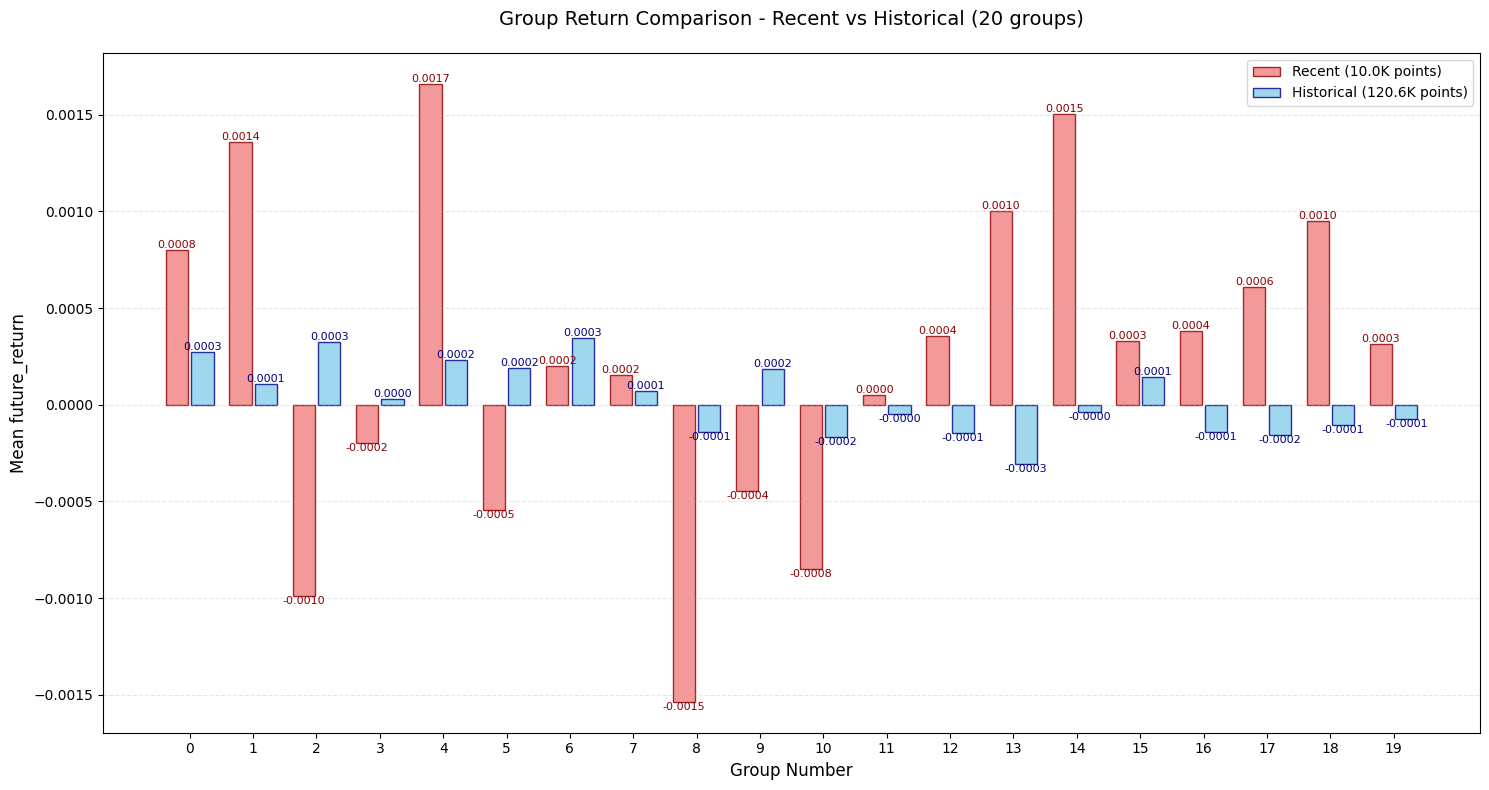

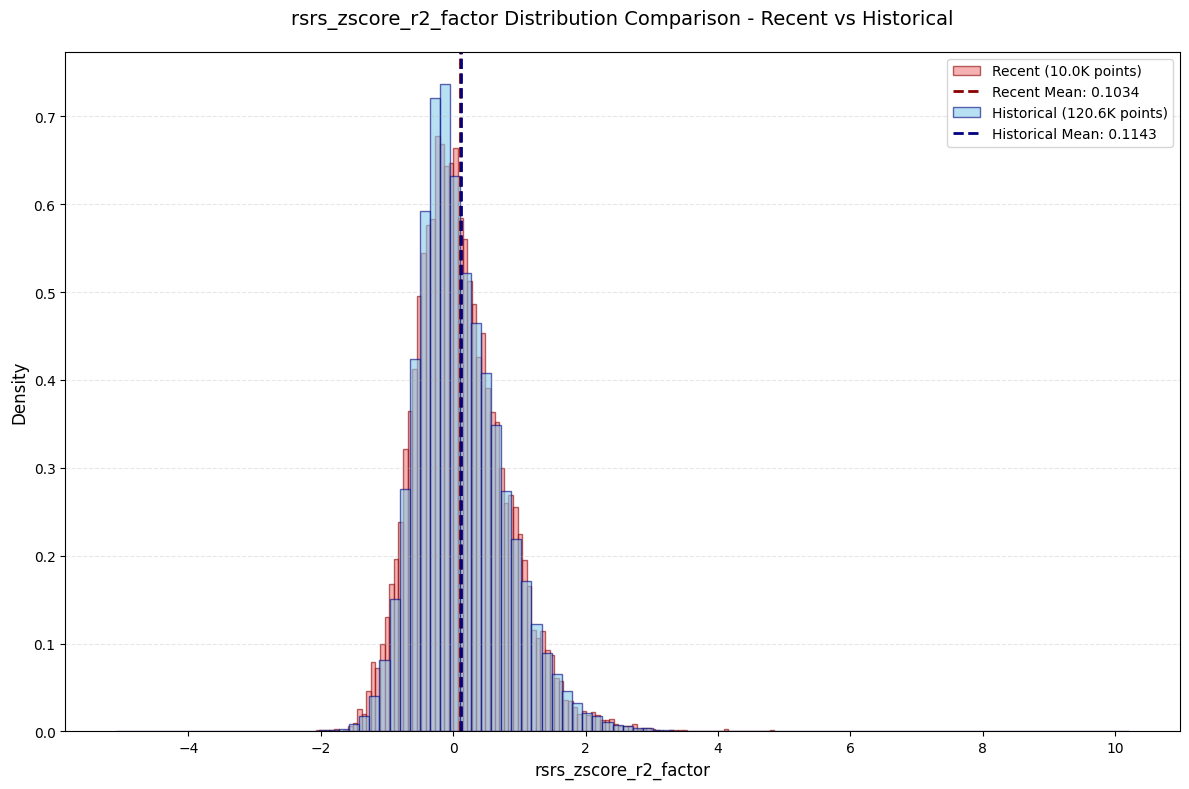

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [6]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)